                                                                   # E-Commerce Customer Segmentation & Prediction                                                                   

## Project Overview 
This project performs customer segmentation using RFM features and clustering techniques such as K-Means, Hierarchical Clustering, and DBSCAN.  
After segmentation, a classification model is built to predict the customer segments.

This analysis helps in:

- Identifying valuable customer groups
- Improving and personalizing marketing strategies
- Enhancing customer retention and loyalty
- Understanding detailed purchasing patterns
- Achieving cost efficiency by focusing on high-value segments
- Improving customer satisfaction through targeted offers

Dataset contains transaction-level data including InvoiceNo, StockCode, Quantity, Price, and InvoiceDate.


In [2]:
#IMPORTING LIBRARIES

In [97]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from mpl_toolkits.mplot3d import Axes3D
import joblib
import warnings 
warnings.filterwarnings('ignore')

In [4]:
#LOAD DATA SET
df =pd.read_csv("data.csv",encoding = 'latin-1')

In [5]:
#BASIC DATASET CHECK

In [6]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [7]:
df.shape

(541909, 8)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [9]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [10]:
df.describe(include='O')

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,10/31/2011 14:41,United Kingdom
freq,1114,2313,2369,1114,495478


In [11]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [12]:
 #DATA CLEANING

In [13]:
# Remove missing CustomerID rows
df = df.dropna(subset=['CustomerID'])
df.shape

(406829, 8)

In [14]:
#convert customer id into string
df['CustomerID'] = df['CustomerID'].astype(str)

In [15]:
# Remove negative quantities
df = df[df['Quantity'] > 0]

In [16]:
#convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],errors='coerce')

In [17]:
#Remove Duplicate rows
df = df.drop_duplicates()

In [18]:
#Add TotalPrice column (Monetary)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [19]:
print(f"Cleaned dataset shape: {df.shape}")

Cleaned dataset shape: (392732, 9)


In [20]:
#TOP SELLING PRODUCTS

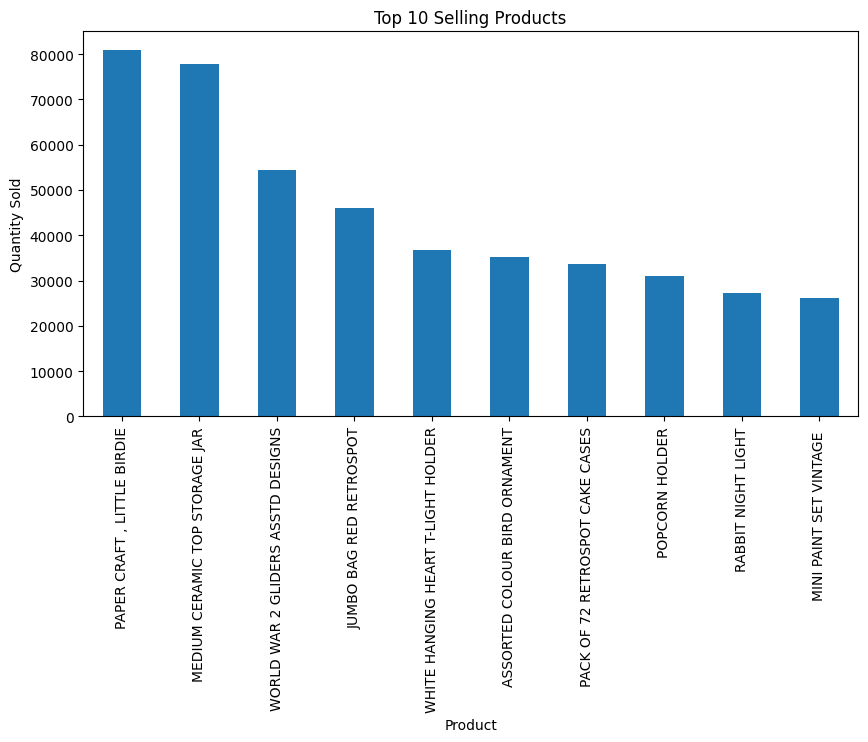

In [21]:
top_products=df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
top_products.plot(kind='bar')
plt.title("Top 10 Selling Products")
plt.xlabel('Product')
plt.ylabel('Quantity Sold')
plt.show()

In [22]:
# MONTHLY SALES TREND

In [23]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])

In [24]:
df['YearMonth']=df['InvoiceDate'].dt.to_period('M')

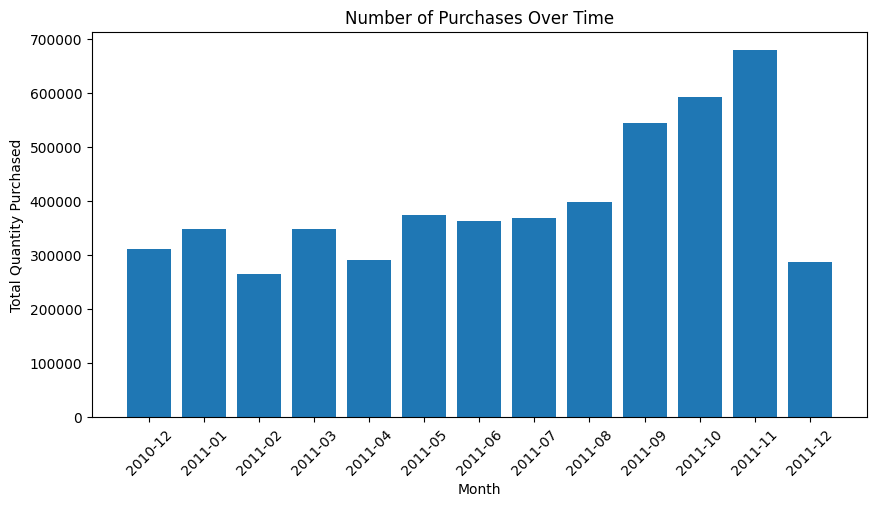

In [25]:
monthly_sales = df.groupby ('YearMonth')['Quantity'].sum().reset_index()
plt.figure(figsize=(10,5))
plt.bar(monthly_sales['YearMonth'].astype(str),monthly_sales['Quantity'])
plt.title("Number of Purchases Over Time")
plt.xticks(rotation=45)
plt.ylabel("Total Quantity Purchased")
plt.xlabel('Month')
plt.show()

In [26]:
#CORRELATION HEATMAP

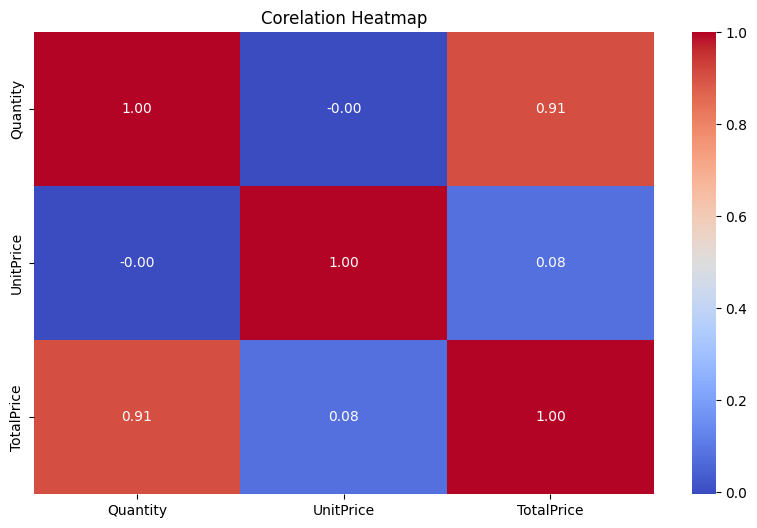

In [27]:
numeric_df =df.select_dtypes(include=['int64','float64'])
plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(),annot=True,cmap='coolwarm',fmt='.2f')
plt.title("Corelation Heatmap")
plt.show()

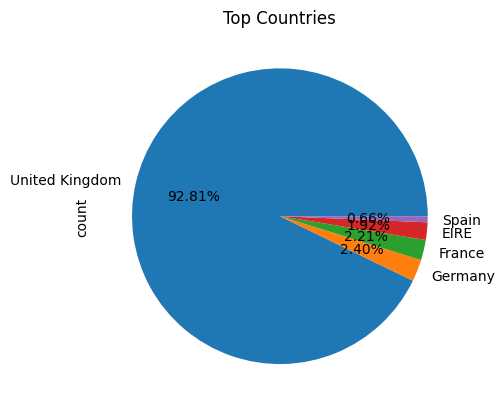

In [28]:
#Country Distribution
df['Country'].value_counts().head().plot(kind='pie', autopct='%1.2f%%', title='Top Countries')
plt.show()

In [29]:
#BUILDING THE RFM MODEL

In [30]:
#Monetary (Total Spend)
rfm_m = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
rfm_m.columns= ['CustomerID','Monetary']
rfm_m.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [31]:
# frequency
rfm_f = df.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns =['CustomerID','Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [32]:
#Merge Monetary + Frequency
rfm = pd. merge(rfm_m ,rfm_f,on='CustomerID',how='inner')
rfm.head()

,CustomerID,Monetary,Frequency
0,12346.0,77183.60,1
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


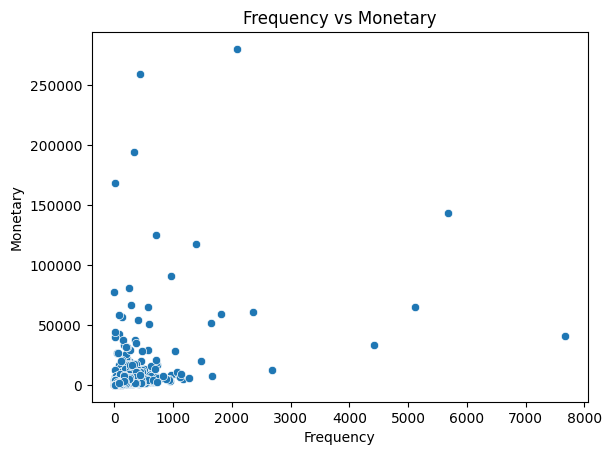

In [33]:
sns.scatterplot(data=rfm, x='Frequency', y='Monetary')
plt.title('Frequency vs Monetary')
plt.show()

In [34]:
#Recencey Calculation(days since last purchase)

In [35]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [36]:
max_date = max(df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [37]:
df['Recency']=max_date-df['InvoiceDate']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,YearMonth,Recency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,373 days 04:24:00


In [38]:
rfm_p =df.groupby('CustomerID')['Recency'].min()
rfm_p=rfm_p.reset_index()
rfm_p.head()

,CustomerID,Recency
0,12346.0,325 days 02:49:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [39]:
rfm_p['Recency']=rfm_p['Recency'].dt.days
rfm_p.head()

,CustomerID,Recency
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [40]:
#Merge into final RFM table

In [41]:
rfm = pd.merge(rfm,rfm_p,on='CustomerID',how='inner')
rfm.columns = ['CustomerID','Monetary','Frequency','Recency']
rfm.head()

,CustomerID,Monetary,Frequency,Recency
0,12346.0,77183.60,1,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [42]:
#Visualize RFM Distributions

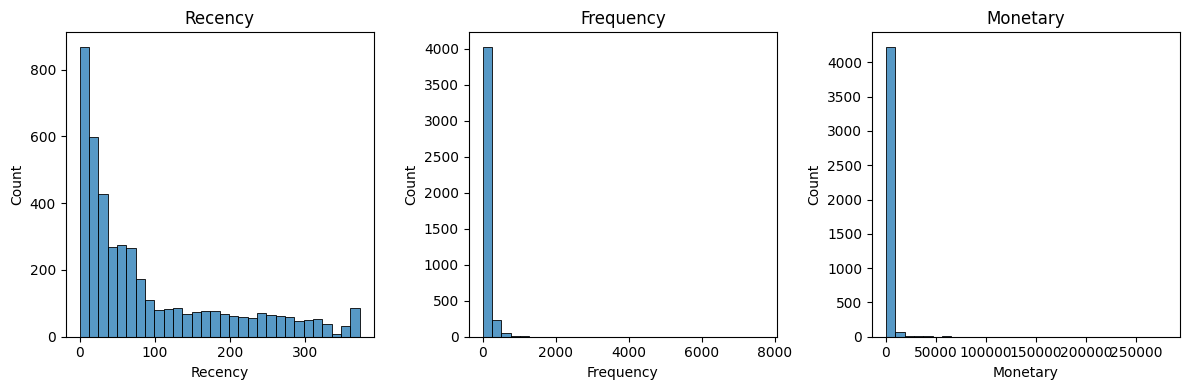

In [43]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.histplot(rfm['Recency'], bins=30)
plt.title('Recency')
plt.subplot(1,3,2)
sns.histplot(rfm['Frequency'], bins=30)
plt.title('Frequency')
plt.subplot(1,3,3)
sns.histplot(rfm['Monetary'], bins=30)
plt.title('Monetary')
plt.tight_layout()
plt.show()

In [44]:
# OUTLIER HANDLING

Text(0.5, 0, 'Attributes')

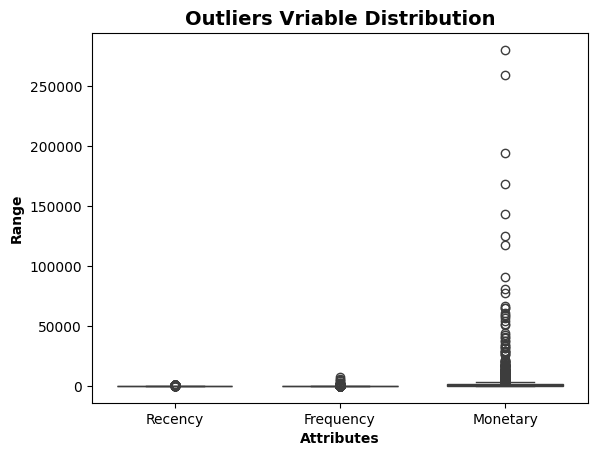

In [45]:
attributes = ['Recency','Frequency','Monetary']
sns.boxplot(data=rfm[attributes],whis=1.5,saturation=1,width=0.7)
plt.title("Outliers Vriable Distribution",fontsize = 14 , fontweight = 'bold')
plt.ylabel("Range",fontweight='bold')
plt.xlabel("Attributes",fontweight = 'bold')

In [46]:
for col in ['Recency', 'Frequency', 'Monetary']:
    rfm[col] = np.where(rfm[col] > rfm[col].quantile(0.95), rfm[col].quantile(0.95), rfm[col])

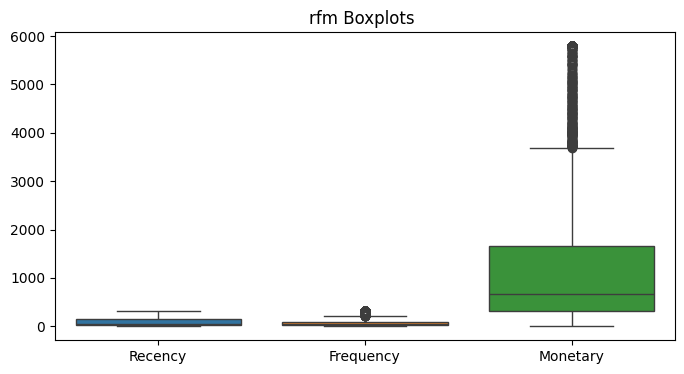

In [47]:
plt.figure(figsize=(8,4))
sns.boxplot(data=rfm[['Recency','Frequency','Monetary']])
plt.title('rfm Boxplots ')
plt.show()

In [48]:
# FEATURE SCALING

In [49]:
rfm_df = rfm[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df)
rfm_scaled.shape

(4339, 3)

In [50]:
# Convert to DataFrame for plotting
rfm_scaled =pd.DataFrame(rfm_scaled)
rfm_scaled.columns=['Recency','Frequency','Monetary']
#rfm_df_scaled.head()

In [51]:
# K-MEANS CLUSTERING (ELBOW METHOD)

In [52]:
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

In [53]:
inertia

[13016.999999999996,
 6826.647335986585,
 3672.61578964165,
 2772.524098652661,
 2329.159543863601,
 1966.1249240166717,
 1794.3750561503887,
 1490.4030048546938,
 1324.4950191686817]

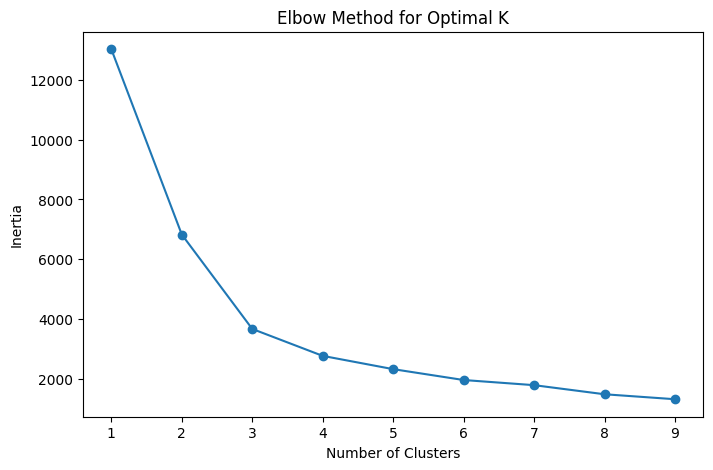

In [54]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [55]:
# Apply K-Means with optimal K=4
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Kmeans_Cluster'] = kmeans.fit_predict(rfm_scaled)

In [56]:
# Assuming KMeans clustering is done and cluster column exists
cluster_summary = rfm.groupby('Kmeans_Cluster')[['Recency', 'Frequency', 'Monetary']].mean()


In [57]:
def interpret_cluster(row):
    r = row['Recency']
    f = row['Frequency']
    m = row['Monetary']
    
    if r < cluster_summary['Recency'].mean() and f > cluster_summary['Frequency'].mean() and m > cluster_summary['Monetary'].mean():
        return "VIP Customers"
    elif r < cluster_summary['Recency'].mean() and f >= cluster_summary['Frequency'].mean():
        return "Loyal Customers"
    elif r > cluster_summary['Recency'].mean() and f < cluster_summary['Frequency'].mean():
        return "Inactive Customers"
    else:
        return "Low Value Customers"

rfm['Segment'] = rfm.apply(interpret_cluster, axis=1)

In [58]:
rfm['Segment'].value_counts()


Segment
Low Value Customers    2043
Inactive Customers     1406
VIP Customers           630
Loyal Customers         260
Name: count, dtype: int64

In [59]:
print("Silhouette Score:", silhouette_score(rfm_scaled, rfm['Kmeans_Cluster']))
print('KMeans Davies-Bouldin:', davies_bouldin_score(rfm_scaled, rfm['Kmeans_Cluster']))

Silhouette Score: 0.46571076673141787
KMeans Davies-Bouldin: 0.8344217527272928


In [60]:
#HIERARCHICAL CLUSTERING

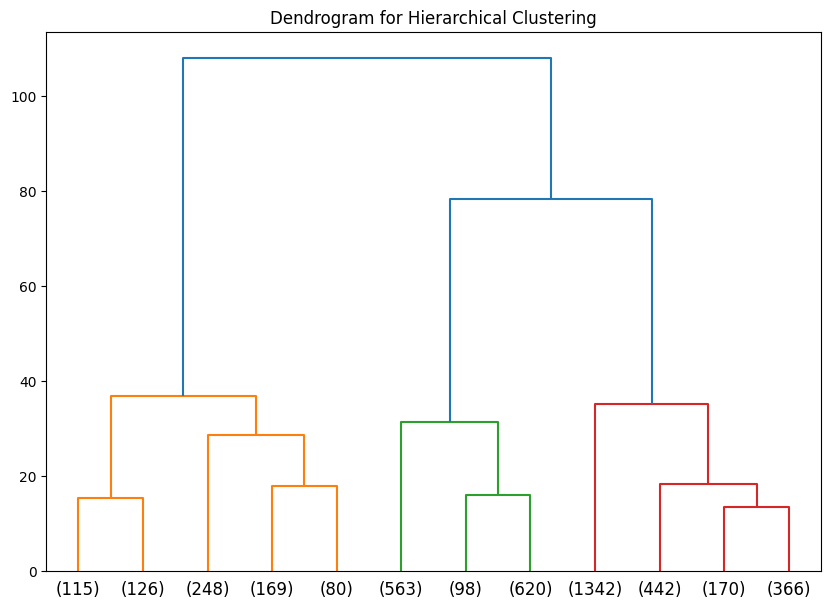

In [61]:
linked = linkage(rfm_scaled, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, truncate_mode='lastp', p=12)
plt.title('Dendrogram for Hierarchical Clustering')
plt.show()

In [62]:
hier = AgglomerativeClustering(n_clusters=4)

In [63]:
rfm['Hier_Cluster'] = hier.fit_predict(rfm_scaled)

In [64]:
print("Silhouette Score:", silhouette_score(rfm_scaled, rfm['Hier_Cluster']))

Silhouette Score: 0.44450815113961156


In [65]:
#DBSCAN CLUSTERING 

In [66]:
db = DBSCAN(eps=0.5, min_samples=5)

In [67]:
rfm['DB_Cluster'] = db.fit_predict(rfm_scaled)

In [68]:
print("Silhouette Score:", silhouette_score(rfm_scaled, rfm['DB_Cluster']))

Silhouette Score: 0.3238454368586304


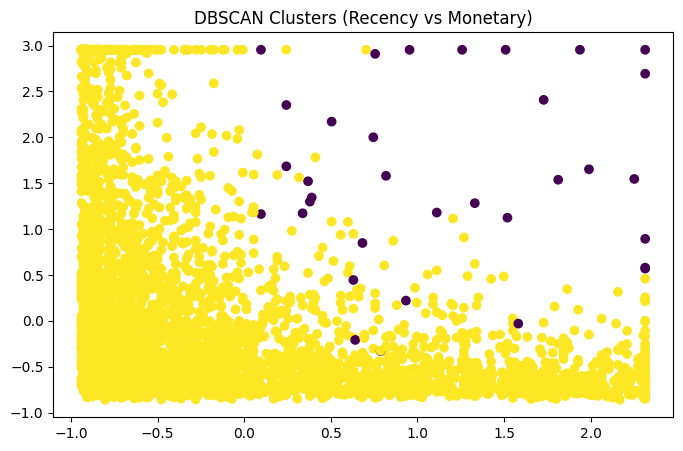

In [69]:
#Visual -2D scatter (Recency vs Monetary) by KMeans 
plt.figure(figsize=(8, 5))
plt.scatter(rfm_scaled['Recency'], rfm_scaled['Monetary'], c=rfm['DB_Cluster'], cmap='viridis')
plt.title('DBSCAN Clusters (Recency vs Monetary)')
plt.show()

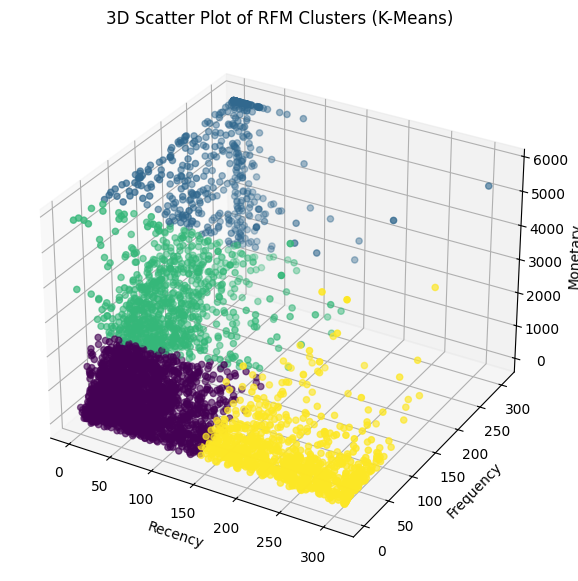

In [70]:
#3D VISUALIZATION OF K-MEANS CLUSTERS
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'], c=rfm['Kmeans_Cluster'], cmap='viridis')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D Scatter Plot of RFM Clusters (K-Means)')
plt.show()

In [71]:
#BUILD CLASSIFICATION MODELS (LOGISTICREGRESSION,DECISION TREE,RANDOMFOREST)

In [72]:
X = rfm[['Recency', 'Frequency', 'Monetary']]

In [73]:
y = rfm['Kmeans_Cluster']

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [75]:
models = {}

In [76]:
# LOGISTICREGRESSION

In [77]:
lr = LogisticRegression(max_iter=500)
lr.fit(scaler.fit_transform(X_train),y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


In [78]:
y_pred_lr =lr.predict(X_test)

In [79]:
models['LogisticRegression']=lr,accuracy_score(y_test,y_pred_lr)

In [80]:
#DECISIONTREE

In [81]:
dt =DecisionTreeClassifier(random_state=42)

In [82]:
dt.fit(X_train, y_train)


,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [83]:
y_pred_dt=dt.predict(X_test)

In [84]:
models['DecisionTree'] = (dt, accuracy_score(y_test,y_pred_dt))

In [85]:
#RandomForest

In [86]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [87]:
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [88]:
y_pred_rf = rf.predict(X_test)

In [89]:
models['RandomForest'] = (rf, accuracy_score(y_test,y_pred_rf))

In [90]:
#Print Model Report
for name, (model, acc) in models.items():
    print(f"Model: {name} - Accuracy: {acc:.4f}")

Model: LogisticRegression - Accuracy: 0.1912
Model: DecisionTree - Accuracy: 0.9827
Model: RandomForest - Accuracy: 0.9862


In [91]:
#classification report RandomForest
print('Classification report (RandomForest):')
print(classification_report(y_test, y_pred_rf))

Classification report (RandomForest):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       384
           1       0.95      0.99      0.97        99
           2       0.99      0.97      0.98       177
           3       1.00      0.98      0.99       208

    accuracy                           0.99       868
   macro avg       0.98      0.98      0.98       868
weighted avg       0.99      0.99      0.99       868



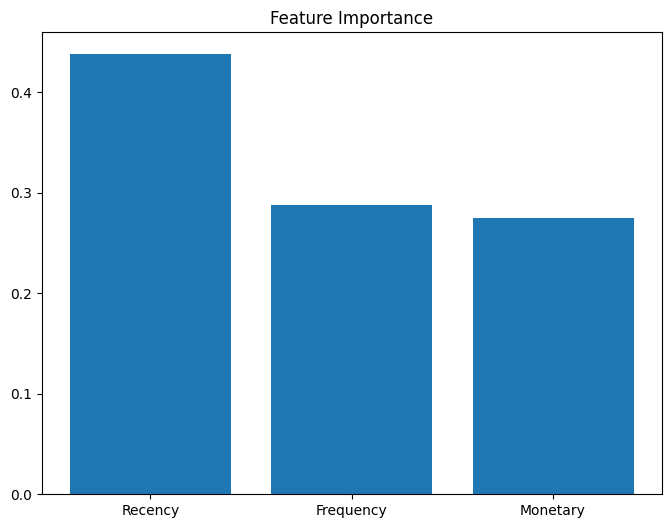

In [92]:
#Feature Importance
importances = rf.feature_importances_
plt.figure(figsize=(8,6))
plt.bar(['Recency', 'Frequency', 'Monetary'], importances)
plt.title('Feature Importance')
plt.show()


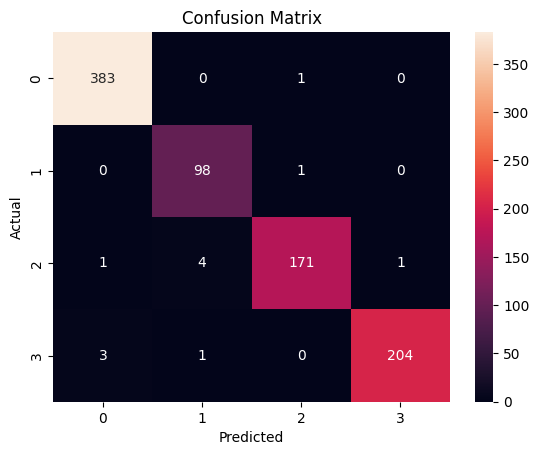

In [93]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


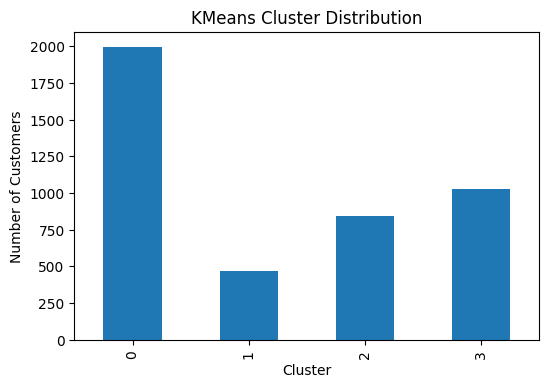

In [94]:
#Cluster Distribution
plt.figure(figsize=(6,4))
rfm['Kmeans_Cluster'].value_counts().sort_index().plot(kind='bar')
plt.title('KMeans Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

In [95]:
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [98]:
joblib.dump(kmeans, "kmeans_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [99]:
model = joblib.load("kmeans_model.pkl")
scaler = joblib.load("scaler.pkl")


In [100]:
new_customer = [[30, 5, 400]]   # Recency, Frequency, Monetary

new_scaled = scaler.transform(new_customer)

segment = model.predict(new_scaled)[0]
segment

np.int32(0)

In [ ]:
print('Final Conclusion:')
print('The customer base was segmented into 4 meaningful groups.')
print('- Outlier capping and scaling helped improve clustering stability.')
print('- K-Means gave the best performance among clustering methods.')
print('- A Random Forest classifier was built to predict customer segments with high accuracy.')
print('- These insights can help in personalized marketing and improving customer retention.')